In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install -q pytorch-lightning
! pip install -q bs4
! pip install -q transformers

     |████████████████████████████████| 707 kB 8.2 MB/s 
     |████████████████████████████████| 5.9 MB 75.5 MB/s 
     |████████████████████████████████| 419 kB 78.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
     |████████████████████████████████| 4.9 MB 7.6 MB/s 
     |████████████████████████████████| 120 kB 73.9 MB/s 
     |████████████████████████████████| 6.6 MB 55.9 MB/s 


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import joblib




from sklearn import preprocessing


from tqdm import tqdm

import itertools
import gc
import albumentations as A
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
from transformers import BeitFeatureExtractor, BeitModel,DistilBertModel, DistilBertConfig, DistilBertTokenizer
import cv2


In [ ]:

class CFG:
  #valid loss 1.13
    debug = False
    image_path = "/content/gdrive/MyDrive/Images"
    captions_path = "/content/gdrive/MyDrive/captions.txt"
    batch_size = 64
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-5
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 40
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #model_name = 'resnet50'
    image_embedding = 768
    text_encoder_model = "distilbert-base-uncased"
    image_encoder_model = "microsoft/beit-base-patch16-224-pt22k"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    image_tokenizer = "microsoft/beit-base-patch16-224-pt22k"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, text_tokenizer,image_tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = text_tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.image_tokenizer = image_tokenizer
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.transforms(image=image)['image']
        encoded_images = self.image_tokenizer(image, return_tensors="pt")
        #item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        
        item['image'] = encoded_images["pixel_values"]
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                #A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                #A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name=CFG.image_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable,tokenizer = CFG.image_tokenizer):
        super().__init__()
        
        self.model = BeitModel.from_pretrained(model_name)
        self.tokenizer  = BeitFeatureExtractor.from_pretrained(tokenizer)
        
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, inputs):
        #print(inputs)
        #inputs = self.tokenizer(, return_tensors="pt")
        #print(inputs)
        output = self.model(pixel_values = inputs)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding

      
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        text_embeddings = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        #print(text_embeddings.size())
        #print(batch["image"])
        img_embeddings = []
        for i in range(len(batch["image"])):
          
          img_embeddings.append(self.image_encoder(batch["image"][i]))
        #image_embeddings = self.image_encoder(batch["image"])
        
        image_embeddings = torch.stack(img_embeddings,1)
       
        image_embeddings = image_embeddings.view(image_embeddings.size()[1],768)
        
        #print("size:",image_embeddings.size())
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_embeddings)
        text_embeddings = self.text_projection(text_embeddings)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

AttributeError: ignored

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}")
    dataframe["id"] = dataframe.index.tolist()
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, text_tokenizer,image_tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        text_tokenizer=text_tokenizer,
        image_tokenizer=image_tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    text_tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    image_tokenizer =  BeitFeatureExtractor.from_pretrained(CFG.image_tokenizer)
    train_loader = build_loaders(train_df, text_tokenizer,image_tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, text_tokenizer,image_tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, CFG.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "/content/gdrive/MyDrive/CLIPmod/Best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [ ]:
main()


In [ ]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    image_tokenizer =  BeitFeatureExtractor.from_pretrained(CFG.image_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer,image_tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            
            img_embeddings = []
            for i in range(len(batch["image"])):
              
                img_embeddings.append(model.image_encoder(batch["image"][i].to(CFG.device)))
            #image_embeddings = model.image_encoder(batch["image"].to(CFG.device))
            
            image_embeddings = torch.stack(img_embeddings,1)
            
            image_embeddings = image_embeddings.view(image_embeddings.size()[1],768)

            image_embeddings = model.image_projection(image_embeddings)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "/content/gdrive/MyDrive/CLIPmod/Best.pt")

Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k were not used when initializing BeitModel: ['layernorm.weight', 'lm_head.bias', 'layernorm.bias', 'lm_head.weight']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint a

In [ ]:
def image_retrieval(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n*5)
    
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

In [ ]:
def image_captioning()

torch.Size([1, 256])
torch.Size([8091, 256])


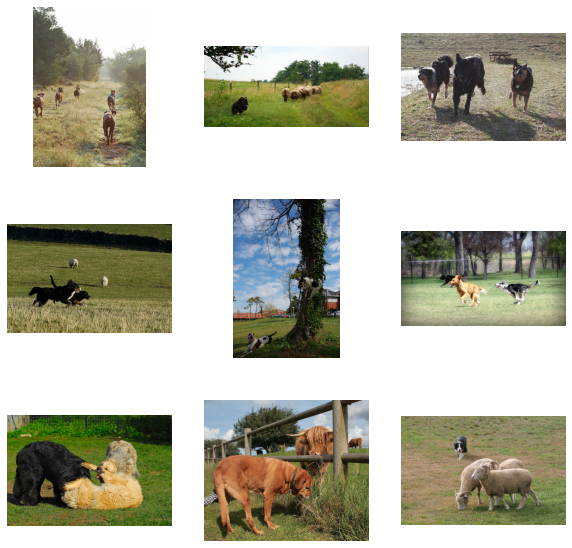

In [ ]:
from matplotlib import pyplot as plt

image_retrieval(model, 
             image_embeddings,
             query="group of dogs on a grassy hill",
             image_filenames=valid_df['image'].values,
             n=9)